In [14]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [15]:
import zipfile
import os

# Define the paths
zip_file_path = '/content/drive/My Drive/archive (7).zip'  # Adjust the path accordingly
destination_folder = '/content/Coral_dataset'

# Create the destination directory if it doesn't exist
if not os.path.exists(destination_folder):
    os.makedirs(destination_folder)

# Extract the zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(destination_folder)

print(f"Extracted files to: {destination_folder}")


Extracted files to: /content/Coral_dataset


In [16]:
data_dir='/content/Coral_dataset'

In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
from torchvision import transforms,datasets
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt


In [18]:
data_transform=transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

In [19]:
dataset=datasets.ImageFolder(data_dir,transform=data_transform)


In [20]:
from torch.utils.data import random_split

In [21]:
train_size=int(0.8*(len(dataset)))
test_size=len(dataset)-train_size

train_dataset,test_dataset=random_split(dataset,[train_size,test_size])

In [22]:
train_loader=DataLoader(train_dataset,batch_size=32,shuffle=True)
test_loader=DataLoader(test_dataset,batch_size=32,shuffle=True)

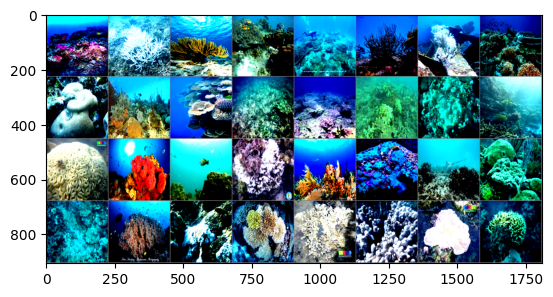

healthy_corals bleached_corals healthy_corals healthy_corals healthy_corals healthy_corals bleached_corals healthy_corals bleached_corals healthy_corals healthy_corals bleached_corals bleached_corals bleached_corals bleached_corals healthy_corals bleached_corals healthy_corals healthy_corals bleached_corals healthy_corals healthy_corals bleached_corals healthy_corals healthy_corals healthy_corals bleached_corals healthy_corals bleached_corals bleached_corals bleached_corals bleached_corals


In [23]:
def imshow(img):
  img=img/2+0.5
  npimg=img.numpy()
  plt.imshow(np.transpose(npimg,(1,2,0)))
  plt.show()


dataiter=iter(train_loader)
images,labels=next(dataiter)
imshow(torchvision.utils.make_grid(images))
print(' '.join(f'{dataset.classes[labels[j]]:5}' for j in range(32)))


In [24]:
class CustomCNN(nn.Module):
  def __init__(self):
    super(CustomCNN,self).__init__()
    self.conv1=nn.Conv2d(3,32,kernel_size=3,padding=1)
    self.conv2=nn.Conv2d(32,64,kernel_size=3,padding=1)
    self.conv3=nn.Conv2d(64,128,kernel_size=3,padding=1)
    self.pool=nn.MaxPool2d(2,2)
    self.fc1=nn.Linear(128*28*28,512)
    self.fc2=nn.Linear(512,256)
    self.fc3=nn.Linear(256,2)

  def forward(self,x):
    x=self.pool(F.relu(self.conv1(x)))
    x=self.pool(F.relu(self.conv2(x)))
    x=self.pool(F.relu(self.conv3(x)))
    x=x.view(-1,128*28*28)
    x=F.relu(self.fc1(x))
    x=F.relu(self.fc2(x))
    x=self.fc3(x)

    return x

device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model=CustomCNN().to(device)

In [27]:
criterion=nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(model.parameters(),lr=0.001)

In [31]:
num_epochs=10
for epoch in range(num_epochs):
  model.train()
  running_loss=0.0
  total=0
  correct=0
  for images,labels in train_loader:
    images=images.to(device)
    labels=labels.to(device)
    optimizer.zero_grad()
    outputs=model(images)
    loss=criterion(outputs,labels)
    loss.backward()
    optimizer.step()
    running_loss+=loss.item()
    _,predicted=torch.max(outputs,1)
    total+=labels.size(0)
    correct+=(predicted==labels).sum().item()

  epoch_loss=running_loss/len(train_loader)
  epoch_acc=correct/total
  print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}')

Epoch 1/10, Loss: 0.3189, Accuracy: 0.8604
Epoch 2/10, Loss: 0.2829, Accuracy: 0.8780
Epoch 3/10, Loss: 0.3035, Accuracy: 0.8537
Epoch 4/10, Loss: 0.2179, Accuracy: 0.8997
Epoch 5/10, Loss: 0.1762, Accuracy: 0.9417
Epoch 6/10, Loss: 0.1841, Accuracy: 0.9390
Epoch 7/10, Loss: 0.1693, Accuracy: 0.9444
Epoch 8/10, Loss: 0.1068, Accuracy: 0.9607
Epoch 9/10, Loss: 0.0783, Accuracy: 0.9702
Epoch 10/10, Loss: 0.0602, Accuracy: 0.9756


In [32]:
model.eval()
test_total=0
test_correct=0
with torch.no_grad():
  for images,labels in test_loader:
    images=images.to(device)
    labels=labels.to(device)
    outputs=model(images)
    _,predicted=torch.max(outputs,1)
    test_total+=labels.size(0)
    test_correct+=(predicted==labels).sum().item()

  test_acc=test_correct/test_total
  print(f'Test Accuracy: {test_acc:.4f}')

Test Accuracy: 0.7243
